In [ ]:
"""
José Javier Calvo Moratilla
MUIARFID 2021-2022
VPC
Gender Detection
.
Dataset: 
"""
#################################################################
# Imports
#################################################################
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.callbacks import ReduceLROnPlateau,  ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121, DenseNet169

import albumentations as A

from keras.utils.np_utils import to_categorical



In [ ]:
#################################################################
# Parameters
#################################################################
batch_size = 128
epochs = 100
num_classes = 2
opt = "adam"

input_folder = "drive/MyDrive/MUIARFID/VPC/Gender/"
data_dat = "drive/MyDrive/MUIARFID/VPC/Gender/data/"



In [ ]:
#################################################################
# Prepare model model saving directory.
#################################################################
save_dir = os.path.join(input_folder, 'saved_models')
name_model = "JJCM_gender_best_model.hdf5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, name_model)

plot_dir = os.path.join(input_folder, 'plots')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)



In [ ]:
#################################################################
# Load data and preprocess
#################################################################
x_train = np.load(data_dat + 'x_train.npy')
x_test = np.load(data_dat + 'x_test.npy')

y_train = np.load(data_dat + 'y_train.npy')
y_test = np.load(data_dat + 'y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)



(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251
(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [ ]:
#################################################################
# Build Data Augmentation
#################################################################
def Augmentor (img):

    transform = A.Compose([
        A.HorizontalFlip(p=0.5), #1
        A.ShiftScaleRotate(p=1.0, shift_limit=(-0.05, 0.05), scale_limit=(-0.05, 0.05), rotate_limit=(-10, 10), border_mode=4), #
        #nuevos       
        A.RandomBrightnessContrast(p=0.2),
        A.ChannelDropout()
    ])
    
    img = 255 * img
    img = img.astype(np.uint8)

    transformed = transform(image=img)
    transformed_img = transformed["image"]
      
    transformed_img = transformed_img.astype('float32')
    transformed_img /= 255
    
    return transformed_img
    
datagen = ImageDataGenerator(preprocessing_function = Augmentor)
datagen.fit(x_train)    



In [ ]:
#################################################################
# Build ReduceLROnPlateau
#################################################################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

#################################################################
# Check point
#################################################################
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)



In [ ]:
#################################################################
# Build the model
#################################################################
model = ResNet50V2(
            include_top=False, weights=None, input_tensor=None,
            input_shape=(100,100,3), pooling='avg', classes=num_classes)

# This is identical to the following:
model_final = Sequential()
model_final.add(model)
model_final.add(Dense(2))
model_final.add(Activation('sigmoid'))

model_final.compile(optimizer = opt , loss='binary_crossentropy', metrics=["accuracy"])

#################################################################
# Early Stooping:
# Stop training when a monitored metric has stopped improving.
#################################################################

early_stop = EarlyStopping(patience= 20, restore_best_weights=True, monitor="val_accuracy")
STEPS = x_train.shape[0] / batch_size
callbacks = [early_stop, checkpoint, reduce_lr]

history = model_final.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch=STEPS,
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1,
                    callbacks=callbacks)



Epoch 1/100
83/82 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.7868
Epoch 1: val_loss improved from inf to 0.96131, saving model to drive/MyDrive/MUIARFID/VPC/Gender/saved_models/JJCM_gender_best_model.hdf5
82/82 [==============================] - 29s 250ms/step - loss: 0.4817 - accuracy: 0.7868 - val_loss: 0.9613 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 2/100
83/82 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8454
Epoch 2: val_loss improved from 0.96131 to 0.42987, saving model to drive/MyDrive/MUIARFID/VPC/Gender/saved_models/JJCM_gender_best_model.hdf5
82/82 [==============================] - 19s 228ms/step - loss: 0.3534 - accuracy: 0.8454 - val_loss: 0.4299 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 3/100
83/82 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8733
Epoch 3: val_loss did not improve from 0.42987
82/82 [==============================] - 16s 196ms/step - loss: 0.3038 - accuracy: 0.8733 - val_

2648/2648 [==============================] - 31s 11ms/step - loss: 0.0840 - accuracy: 0.9713
Test loss: 0.08395407348871231
Test accuracy: 0.9712991118431091


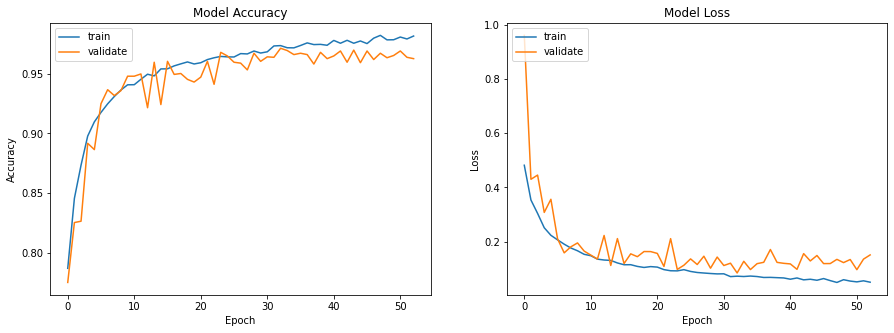

In [ ]:
#################################################################
# Stats Train
#################################################################

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.savefig(input_folder + '/plots/resnet50v2_gender.png')
    plt.show()

#################################################################
# Load the best model obtained
#################################################################
best_model = ResNet50V2(
            include_top=False, weights=None, input_tensor=None,
            input_shape=(100,100,3), pooling='avg', classes=num_classes)

model_final = Sequential()
model_final.add(best_model)
model_final.add(Dense(2))
model_final.add(Activation('sigmoid'))


model_final.compile(optimizer = opt ,loss='binary_crossentropy', metrics=["accuracy"]) 
model_final.load_weights(filepath)
scores = model_final.evaluate(x_test, y_test, steps = len(x_test), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])  
plotmodelhistory(history)